In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import re
import squarify

from functions import run_proportional_scaling, run_linear_programming
from helpers import fetch_area_data, get_variables
from tree import build_tree, fetch_branch, fetch_values_given_key, get_subindustries_data, get_constraints, write_into
from config import settings

In [2]:
print('51163 Rockbridge County, Virginia')
df, url = fetch_area_data('2021',4,'51163')

51163 Rockbridge County, Virginia


In [3]:
# https://www.bls.gov/cew/classifications/aggregation/agg-level-titles.htm
total_establishments = int(df[df['agglvl_code']==70][settings.establishments])
print(f"Total establishments in the county: {total_establishments}") 
aggregations = range(74,78+1)
for aggregation in aggregations:
    print(f"The sum of establishment counts at level {aggregation}: {np.sum(df[df['agglvl_code']==aggregation][settings.establishments])}")

Total establishments in the county: 542
The sum of establishment counts at level 74: 542
The sum of establishment counts at level 75: 542
The sum of establishment counts at level 76: 542
The sum of establishment counts at level 77: 542
The sum of establishment counts at level 78: 542


In [4]:
# cast data into a tree structure with nested mappings
# county = {'ind': 10, 'est': 533, 'emp': 5937, children': [{}, {}, ...]}
county = build_tree(df, '10', 71)

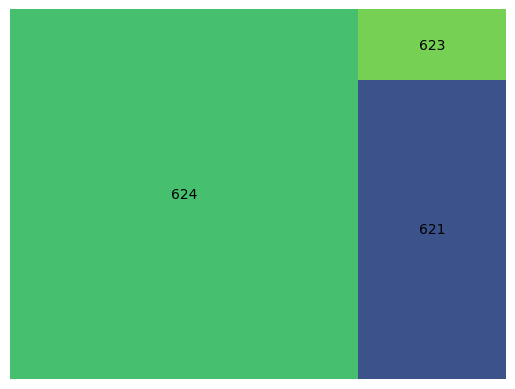

In [5]:
# Return industry details
industry = fetch_branch(county, 'ind', '62')
sub_industries = [sub_industry['ind'] for sub_industry in industry['children']]
est = [sub_industry['est'] for sub_industry in industry['children']]

sub_industries_sorted = [ind for _, ind in sorted(zip(est, sub_industries), reverse=True)]
est_sorted = sorted(est, reverse=True)
squarify.plot(sizes=est_sorted, label=sub_industries_sorted)
plt.axis('off')
plt.show()

In [6]:
# Proportional scaling example
industry = fetch_branch(county, 'ind', '10')
print('*** overall number of establishments ***')
print(industry['est'])
print('*** overall employment ***')
print(industry['emp'])
print('*** sub industries ***')
print([sub_industry['ind'] for sub_industry in industry['children']])
print('*** number of establishments in the sub industries ***')
print([sub_industry['est'] for sub_industry in industry['children']])
print('*** employment in the sub industries ***')
print([sub_industry['emp'] for sub_industry in industry['children']])
print('*** employment approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
employment = np.array([sub_industry['emp'] for sub_industry in industry['children']],dtype = object)
employment_ps = employment.copy()
undisclosed_est = np.sum(establishments[np.where(employment==0)])
undisclosed_emp = industry['emp'] - np.sum(employment)
employment_ps[np.where(employment==0)] = establishments[np.where(employment==0)]/undisclosed_est*undisclosed_emp
print(employment_ps)
print('*** wages in the sub industries ***')
print([sub_industry['wages'] for sub_industry in industry['children']])
print('*** wages approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
wages = np.array([sub_industry['wages'] for sub_industry in industry['children']],dtype = object)
wages_ps = wages.copy()
undisclosed_est = np.sum(establishments[np.where(wages==0)])
undisclosed_wages = industry['wages'] - np.sum(wages)
wages_ps[np.where(wages==0)] = establishments[np.where(wages==0)]/undisclosed_est*undisclosed_wages
print(wages_ps)



*** overall number of establishments ***
512
*** overall employment ***
4752
*** sub industries ***
['11', '21', '22', '23', '31_33', '42', '44_45', '48_49', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '99']
*** number of establishments in the sub industries ***
[17, 1, 2, 74, 25, 13, 62, 17, 9, 18, 9, 33, 2, 26, 5, 87, 13, 46, 41, 12]
*** employment in the sub industries ***
[0, 0, 0, 369, 897, 0, 1196, 77, 29, 106, 18, 0, 0, 0, 69, 507, 112, 584, 148, 17]
*** employment approximation proportional scaling ***
[112.67021276595746 6.627659574468085 13.25531914893617 369 897
 86.15957446808511 1196 77 29 106 18 218.7127659574468 13.25531914893617
 172.31914893617022 69 507 112 584 148 17]
*** wages in the sub industries ***
[0, 0, 0, 5804030, 10083092, 0, 9508668, 1079078, 400983, 1485148, 279793, 0, 0, 0, 683429, 5824644, 1057960, 3722327, 1286572, 142041]
*** wages approximation proportional scaling ***
[1471543.510638298 86561.3829787234 173122.7659574468 5804030

In [7]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = employment,
        name = 'employment'
    )
)
fig.add_trace(
    go.Bar(
        y = employment_ps,
        name = 'employment ps'
    )
)
fig.update_layout(
    title='Employment and employment approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [8]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = wages,
        name = 'wages'
    )
)
fig.add_trace(
    go.Bar(
        y = wages_ps,
        name = 'wages ps'
    )
)
fig.update_layout(
    title='Wages and wages approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [9]:
# loop through the entire tree
for ind in fetch_values_given_key(county, 'ind', []):
    industry = fetch_branch(county, 'ind', ind)
    data = get_subindustries_data(industry)
    county = run_proportional_scaling(county, industry, data)

In [10]:
# Define constraints
constraints = get_constraints(county, 'emp', [])
variables = []
for constraint in constraints:
    variables+=re.findall(r"epe_[^ ]* ", constraint)

# Define variables
for variable in variables:
    exec(f"{variable} = cp.Variable()")

# Define the objective function
exec(f"objective = cp.Minimize(cp.abs({constraints[0].replace('=', '-').replace('+', '-')}))")

# Define numerical constraints
numerical_constraints = []
for i,constraint in enumerate(constraints):
    if i > 0:
        numerical_constraints.append(eval(f"{constraint.replace('=','==')}"))
# Adding non-negativity constraints for the variables
for variable in variables:
    numerical_constraints.append(eval(f"{variable}>= 0"))

# Form and solve the problem
problem = cp.Problem(objective, numerical_constraints)
problem.solve()

2.2737367544323206e-13

In [11]:
for variable in variables:
    ind = variable[variable.find('_')+1:-1]
    branch = fetch_branch(county, 'ind', ind)
    if branch['emp'] == 0:
        write_into(
            county, 'ind', branch['ind'],
            {'emp_lp': branch['est'] * eval(f"float({variable}.value)")}
        )


In [12]:
industry = fetch_branch(county, 'ind', '5221')
print(industry['est'])
print(industry['emp'])
if industry.get('emp_ps') is not None:
    print(f"emp_ps {industry['emp_ps']}")
if industry.get('emp_lp') is not None:
    print(f"emp_lp {industry['emp_lp']}")
for child in industry['children']:
    print(f"*** ind {child['ind']} *** ")
    print(child['est'])
    print(child['emp'])
    if child.get('emp_ps') is not None:
        print(f"emp_ps {child['emp_ps']}")
    if child.get('emp_lp') is not None:
        print(f"emp_lp {child['emp_lp']}")

9
0
emp_ps 72.81818181818181
emp_lp 79.29766581975292
*** ind 52211 *** 
8
74
*** ind 52213 *** 
1
0
emp_ps -1.181818181818187
emp_lp 5.297665819752922


In [13]:
# download all 6 digit codes or make a treemap
# for ind in fetch_values_given_key(county, 'ind', []):
#     if len(ind) == 6:
#         print(fetch_branch(county, 'ind', ind)) 

In [14]:
# Fetch all industry codes in a period
years = list(range(2014,2021+1))
industry_codes = []
for year in years:
    df, url = fetch_area_data(year,4,'51163')
    county = build_tree(df, '10', 71)
    industry_codes+=fetch_values_given_key(county, 'ind', [])
time_series = pd.DataFrame([], columns=np.unique(industry_codes)) 

In [15]:
# Run LP on all industries and all the years and save to time_series
for year in years:
    df, url = fetch_area_data(year,4,'51163')
    county = build_tree(df, '10', 71)
    county = run_linear_programming(county, 'emp')
    for ind in industry_codes:
        industry = fetch_branch(county, 'ind', ind)
        if industry is not None:
            if industry.get('emp_lp') is not None:
                time_series.at[year, ind] = industry['emp_lp']
            else:
                time_series.at[year, ind] = industry['emp']

In [18]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = years,
        y = time_series['5221']
    )
)
fig.update_layout(
    title='Employment approximation with LP',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [17]:
time_series

,10,11,111,1114,11142,111422,1119,11199,111998,112,...,813920,814,8141,81411,814110,99,999,9999,99999,999999
2014,4177,56.229065,6.114532,6.114532,6.114532,6.114532,NaN,NaN,NaN,33,...,NaN,12.99825,12.99825,12.99825,12.99825,NaN,NaN,NaN,NaN,NaN
2015,4512,65.639056,12.274269,6.137135,6.137135,6.137135,6.137135,6.137135,6.137135,36,...,5.494495,25.429255,25.429255,25.429255,25.429255,4,4,4,4,4
2016,4669,59.843878,6.421939,6.421939,6.421939,6.421939,0.0,0.0,0.0,32,...,7.217401,28,28,28,28,10,10,10,10,10
2017,5044,69.558556,7.709964,7.709964,7.709964,7.709964,NaN,NaN,NaN,32,...,4.421044,38,38,38,38,9,9,9,9,9
2018,5128,77.678911,11.039805,11.039805,11.039805,11.039805,NaN,NaN,NaN,29,...,NaN,30,30,30,30,4,4,4,4,4
2019,5229,75.36038,12.217991,12.217991,12.217991,12.217991,NaN,NaN,NaN,27,...,NaN,14,14,14,14,5,5,5,5,5
2020,4709,77.155342,11.151385,0.0,0.0,0.0,11.151385,11.151385,11.151385,31,...,NaN,8,8,8,8,17,17,17,17,17
2021,4752,80.947158,11.139316,NaN,NaN,NaN,11.139316,11.139316,11.139316,35,...,NaN,7,7,7,7,17,17,17,17,17


In [24]:
time_series.pct_change().std().sort_values(ascending=False)

238351    3.277609e+14
23835     3.182216e+14
5411      3.081535e+00
54111     3.081535e+00
541110    3.081535e+00
              ...     
713910             NaN
81143              NaN
811430             NaN
81299              NaN
812990             NaN
Length: 540, dtype: float64

In [20]:
time_series.to_csv('Rockbridge.csv')